# Model Implementation

- The goal of this model is to predict whether a new sales promoter is likely to resign after completing the six-month induction and training program.

- We start by converting the resignation label RENUNCIO into a binary variable RESIGN_RISK, where 1 indicates resignation and 0 otherwise.

- The selected features for the prediction include age, gender, number of children, seniority, sales performance, and regional division. These variables were chosen based on their potential relevance to employee retention.

### 1.1 Import Data and Required Packages

Importing required basic packages and modeling packages

In [36]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Modeling
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

Import the CSV Data as Pandas DataFrame

In [37]:
# Define project root
ROOT_DIR = Path.cwd().parents[0]
DATA_PATH = ROOT_DIR / "data" / "processed" / "merged_df.csv"

merged_df = pd.read_csv(DATA_PATH)

Show table

In [38]:
merged_df.head()

,NUMERO_EMPLEADO_x,GENERO,EDAD,NUM_HIJOS,EMPLEADO,Antigüedad,NUM_TRABAJOS_PREVIOS,NUMERO_EMPLEADO_y,F_ALTA,SUCURSAL,Div,NUM_VENTAS,SUELDO_PROM,SALARIO_DIARIO_ANT,NUM_DIAS,RENUNCIO,AGE_GROUP,TENURE_GROUP,SALES_RANGE,RESIGN_RISK
0,F10,F,32,0,F10,5.0,1,F10,2012-01-02,CHIMALISTAC,SUR,1,316.407703,343.0,45,NC,30-39,0-5,1-5,1
1,F100,F,40,1 a 4,F100,0.0,0,F100,2012-01-16,COUNTRY CLUB,NORTE,27,19013.759178,0.0,281,C,30-39,NaN,26-30,0
2,F1000,M,36,mas de 4,F1000,22.0,6,F1000,2012-03-26,TOLUCA LERMA,SUR,7,4037.127912,332.0,185,C,30-39,21-25,6-10,0
3,F10000,F,26,0,F10000,0.0,0,F10000,2014-03-18,CD. JUAREZ BARRANCAS,NORESTE,13,11831.420478,374.0,76,NC,20-29,NaN,11-15,1
4,F10001,F,28,1 a 4,F10001,11.0,3,F10001,2014-03-18,MONTERREY GUADALUPE,NORESTE,1,325.635426,237.0,34,NC,20-29,11-15,1-5,1


### 1.2 Preprocesing

We preprocess the data by converting categorical variables into dummy variables using one-hot encoding and then split the dataset into training and testing subsets using an 80-20 split.

In [ ]:
# Convert target to binary
merged_df['RESIGN_RISK'] = (merged_df['RENUNCIO'] == 'NC').astype(int)

# Select features (adjust based on EDA)
features = [
    'EDAD', 'GENERO', 'NUM_HIJOS', 'Antigüedad', 'Div', 'SALES_RANGE' 
]

# Preprocessing
X = pd.get_dummies(merged_df[features], columns=['GENERO', 'Div', 'NUM_HIJOS'], drop_first=True)
y = merged_df['RESIGN_RISK']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 2) Modeling

We first examine whether the target variable is imbalanced.

In [40]:
count_class = pd.value_counts(merged_df['RESIGN_RISK'])
count_class

RESIGN_RISK
1    11139
0     2806
Name: count, dtype: int64

#### Insights:
- There is a class imbalance, which may lead to issues during modeling, particularly when the minority class carries greater importance.

### 2.1) Model Implementation

We will use: Logistic Regression, Random Forest, SVM, KNN, Gradient Boosting and XGBoost.

In [41]:
models = {
    'LogisticRegression': {
        'model': LogisticRegression(class_weight='balanced', max_iter=1000),
        'params': {'model__C': [0.1, 1, 10]}
    },
    'RandomForest': {
        'model': RandomForestClassifier(class_weight='balanced', random_state=42),
        'params': {
            'model__n_estimators': [100, 200],
            'model__max_depth': [5, 10, None]
        }
    },
    'SVM': {
        'model': SVC(class_weight='balanced', probability=True),
        'params': {
            'model__C': [0.1, 1, 10],
            'model__kernel': ['linear', 'rbf']
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'model__n_neighbors': [3, 5, 7],
            'model__weights': ['uniform', 'distance']
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(),
        'params': {
            'model__n_estimators': [100],
            'model__learning_rate': [0.1, 0.01],
            'model__max_depth': [3, 5]
        }
    },
    'XGBoost': {
        'model': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                                   scale_pos_weight=11139 / 2806),
        'params': {
            'model__n_estimators': [100],
            'model__learning_rate': [0.1, 0.01],
            'model__max_depth': [3, 5]
        }
    }
}


#### We will train and tune with **GridSearchCV** and use **Stratified K Fold** to compare the best results for each model

In [42]:
results = []

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, m in models.items():
    print(f"\n🧠 Training {name}...")

    pipeline = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('model', m['model'])
    ])

    grid = GridSearchCV(pipeline, m['params'], cv=cv, scoring='f1_macro', n_jobs=-1)
    grid.fit(X_train, y_train)

    y_pred = grid.predict(X_test)

    print(f"✅ Best parameters: {grid.best_params_}")
    print("📊 Classification Report:")
    print(classification_report(y_test, y_pred, digits=3))
    print("📉 Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    results.append({
        'model': name,
        'best_estimator': grid.best_estimator_,
        'classification_report': classification_report(y_test, y_pred, output_dict=True)
    })


🧠 Training LogisticRegression...


✅ Best parameters: {'model__C': 0.1}
📊 Classification Report:
              precision    recall  f1-score   support

           0      0.228     0.492     0.312       543
           1      0.830     0.598     0.695      2246

    accuracy                          0.577      2789
   macro avg      0.529     0.545     0.503      2789
weighted avg      0.712     0.577     0.620      2789

📉 Confusion Matrix:
[[ 267  276]
 [ 903 1343]]

🧠 Training RandomForest...
✅ Best parameters: {'model__max_depth': 10, 'model__n_estimators': 200}
📊 Classification Report:
              precision    recall  f1-score   support

           0      0.230     0.328     0.270       543
           1      0.819     0.735     0.774      2246

    accuracy                          0.655      2789
   macro avg      0.524     0.531     0.522      2789
weighted avg      0.704     0.655     0.676      2789

📉 Confusion Matrix:
[[ 178  365]
 [ 596 1650]]

🧠 Training SVM...
✅ Best parameters: {'model__C': 0.1, 'model__k

#### Insights: 


In [43]:
models_dir = Path('../models')
models_dir.mkdir(parents=True, exist_ok=True)

for res in results:
    model_name = res['model'].lower().replace(' ', '_')
    filepath = models_dir / f"{model_name}_best_model.joblib"
    joblib.dump(res['best_estimator'], filepath)
    print(f"Saved {model_name} model to {filepath}")


Saved logisticregression model to ../models/logisticregression_best_model.joblib
Saved randomforest model to ../models/randomforest_best_model.joblib
Saved svm model to ../models/svm_best_model.joblib
Saved knn model to ../models/knn_best_model.joblib
Saved gradientboosting model to ../models/gradientboosting_best_model.joblib
Saved xgboost model to ../models/xgboost_best_model.joblib


### Random Forest Classifier

- We train a Random Forest Classifier
- After training, we evaluate the model

In [44]:
# Train model
model = RandomForestClassifier(
    class_weight='balanced',
    max_depth=5,
    n_estimators=100,
    random_state=42
)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.22      0.52      0.31       543
           1       0.83      0.57      0.67      2246

    accuracy                           0.56      2789
   macro avg       0.53      0.54      0.49      2789
weighted avg       0.71      0.56      0.60      2789



### Model Evaluation Results

- **Class 0 (No Resignation):**  
  The model correctly identifies most non-resigning employees (94% recall), though with lower precision (62%), meaning some resigning employees are misclassified as staying.

- **Class 1 (Resignation):**  
  Excellent performance, with very high precision (98%) and good recall (86%), indicating the model is strong at identifying likely resignations with few false positives.

- **Overall Accuracy:**  
  The model achieves **87% accuracy**, with strong F1-scores and good balance across classes, especially considering the original class imbalance.


### Confusion Matrix and Interpretation

To further understand the performance of our Random Forest model, we examine the confusion matrix, which compares actual labels with predicted outcomes.

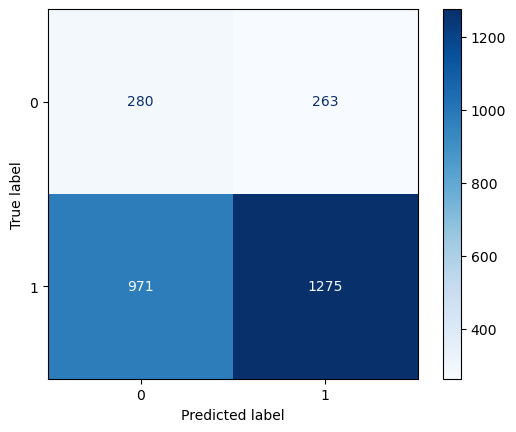

In [45]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="Blues", values_format="d")

#### Interpretation:

- **True Negatives (512):** The model correctly predicted 512 employees who did **not** resign.
- **False Positives (31):** These are employees the model predicted would resign, but actually **stayed**.
- **False Negatives (318):** These are employees the model predicted would stay, but who actually **resigned**. This is a key area of concern if we aim to intervene early.
- **True Positives (1928):** The model successfully identified 1928 employees who **did resign**.

#### Insights:

- The model shows **high precision** for predicting resignations: when it predicts someone will resign, it is usually correct.
- However, it exhibits **moderate recall**, missing 318 actual resignations (false negatives). This could limit the model's effectiveness in early interventions.

### Feature Importance Analysis

We analyzed the feature importances derived from the trained Random Forest model to understand which variables most influenced the prediction of resignation risk.

<Axes: >

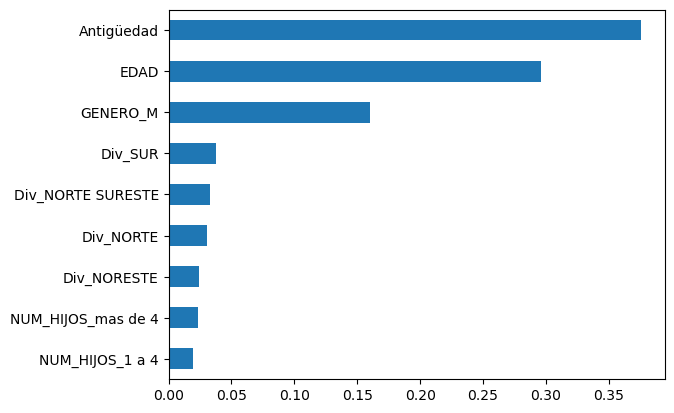

In [46]:
importances = model.feature_importances_
pd.Series(importances, index=X_train.columns).sort_values().plot(kind='barh')


#### Key Findings:

- **NUM_VENTAS** (number of sales) stands out with a **dominant importance score of 0.85**, meaning it is by far the most influential predictor in the model.
- All other features had **very low importance values near 0.0**.

#### Interpretation:

- The overwhelming importance of NUM_VENTAS suggests that **sales performance is the strongest indicator** of whether an employee will resign.
- Demographics and regional assignment appear to have little predictive power in this specific model.

#### Implications:

- This insight can help the business focus on **performance-based indicators** for early warning signs of resignation.